# Example of how to read and parse the data file save from the rogue software

In [1]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
from scipy.stats import norm
from scipy.optimize import curve_fit
top_level=f'{os.getcwd()}/..'
filePath = f'{top_level}/data/ExampleDatfileAnalysis_NewFormat.dat'
print(filePath)

/afs/slac.stanford.edu/u/re/ruckman/projects/kek-bpm-rfsoc-dev/software/notebooks/../data/ExampleDatfileAnalysis_NewFormat.dat


In [2]:
# Waveforms variables to be filled 
ampFault = { i : []  for i in range(4) }  
xPosFault = []
yPosFault = []
qBunchFault = []

# Open the .dat file
with fileio.FileReader(files=filePath) as fd:
    
    # Loop through the file data
    for header,data in fd.records():

        # Check if there is a 8-byte header in the frame
        if (header.flags==0):
            hdrOffset = 8
            hdr = struct.unpack("<d", data[:8])[0]
            timestamp = time.localtime(hdr)
            # Define the desired format string (replace with your preferred format)
            # Some common format specifiers:
            # %Y - Year with century
            # %m - Month as a decimal number (01-12)
            # %d - Day of the month as a decimal number (01-31)
            # %H - Hour in 24-hour format (00-23)
            # %M - Minute (00-59)
            # %S - Second (00-59)
            formatted_time = time.strftime('%Y-%m-%d %H:%M:%S', timestamp)
            print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
        else:
            hdrOffset = 0
            print( 'No timestamp header detected' )
        
        # Check for error in frame
        if (header.error>0):
            # Look at record header data
            print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
            print(f"Record size    = {header.size}")
            print(f"Record channel = {header.channel}")
            print(f"Record flags   = {header.flags:#x}")
            print(f"Record error   = {header.error:#x}")

        # Check if AMP Fault waveform
        elif (header.channel < 16) and (header.channel >= 12):
            ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))

        # Check if AMP Live waveform
        elif header.channel == 24:
            fpData = data[hdrOffset:].view(np.float32)
            fpDataLen = len(fpData)
            xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
            yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
            qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
        
        # Else undefined stream index
        else:
            print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')

CH=12: Event Timestamp in human-readable format: 2024-06-04 20:33:41
CH=13: Event Timestamp in human-readable format: 2024-06-04 20:33:41
CH=15: Event Timestamp in human-readable format: 2024-06-04 20:33:41
CH=14: Event Timestamp in human-readable format: 2024-06-04 20:33:41


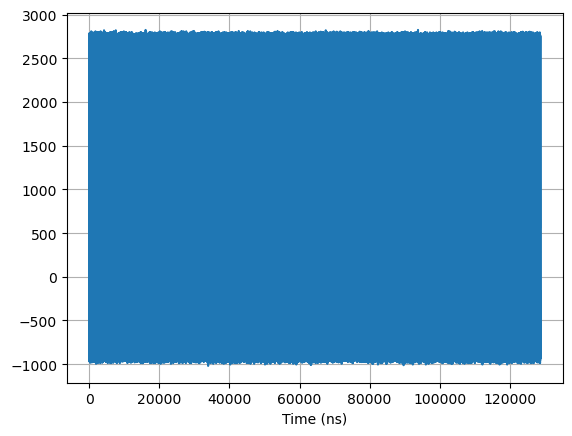

In [3]:
size = len(ampFault[0][0])
timeBin = 1.0/(0.509*8.0) # Unit of ns for 4.072 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.plot(timeSteps,ampFault[0][0])
plt.xlabel("Time (ns)")
plt.grid()

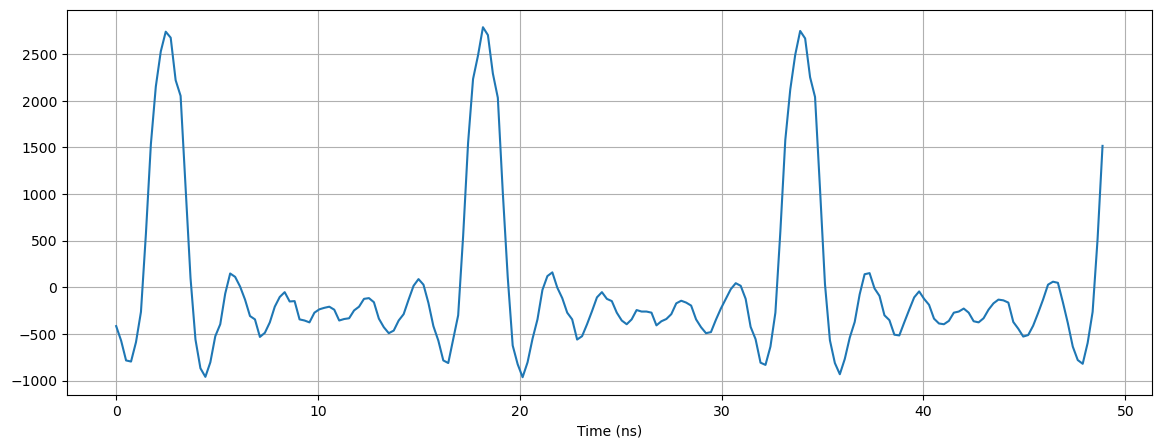

In [4]:
plt.figure(figsize=(14,5))
plt.plot(timeSteps[0:200],ampFault[0][0][0:200])
plt.xlabel("Time (ns)")
plt.grid()